In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # Look at RF for package
import numpy as np
import tensorflow as tf
import pylab as pl
% pylab inline
RANDOM_SEED = np.random.seed(20170301)

Populating the interactive namespace from numpy and matplotlib


# Simple MLP using tensor flow
Adapted from a basic feedforward MLP developed by Vinh Khuc https://gist.github.com/vinhkhuc/e53a70f9e5c3f55852b0

1 hidden layer

In [2]:
data_directory = "/Users/Daynan/CUSP/usi/gas_leaks/processed_data"

# get 2013, 2014, and 2015 data for zipcode
init_tract_2013 = pd.read_csv(data_directory+'/pluto_fdny_dob_census_to_tract_2013.csv')
init_tract_2014 = pd.read_csv(data_directory+'/pluto_fdny_dob_census_to_tract_2014.csv')
init_tract_2015 = pd.read_csv(data_directory+'/pluto_fdny_dob_census_to_tract_2015.csv')

Bonus: A look at the top tracts

In [3]:
def top_cut(data,target_col,thresh='mean',qt=None):
    temp = data.copy()
    temp.fillna(0, inplace=True)
    temp = temp.replace(np.inf, 0)
    mn = temp[target_col].mean()
    if thresh=='mean':
        return temp[temp[target_col]>mn]
    elif thresh=='quant':
        qt_val = temp[target_col].quantile(qt)
        return temp[temp[target_col]>qt_val]
    else:
        return temp[temp[target_col]>thresh]

In [4]:
# cut - 25th quantile (i.e. top 75%)
cut_tract_2013 = top_cut(init_tract_2013,'total_gas_incidents',thresh='quant',qt=.25)
cut_tract_2014 = top_cut(init_tract_2014,'total_gas_incidents',thresh='quant',qt=.25)
cut_tract_2015 = top_cut(init_tract_2015,'total_gas_incidents',thresh='quant',qt=.25)

In [5]:
def preprocess_and_split(train_data,test_data,units=True):
    """Takes initial dataframes for train and test/validate, processes, 
    and returns x_train, y_train,x_test,y_test."""
    
    if units:
        drop_col = 'total_gas_incidents'
    else:
        drop_col = 'gas_incidents_per_bldg_unit'
        
    # replace 0 and inf and error zipcode
    # train
    train_data.fillna(0, inplace=True)
    train_data = train_data.replace(np.inf, 0)
 
    train_data = train_data.drop(['NTACode', 'NTAName', 'geometry', 
                                  'ZipCode', drop_col, 'GEOID'],axis=1).copy()
    
    # test/validate
    test_data.fillna(0, inplace=True)
    test_data = test_data.replace(np.inf, 0)
    test_data = test_data.drop(['NTACode', 'NTAName', 'geometry', 
                                  'ZipCode', drop_col, 'GEOID'],axis=1).copy()

    # add variables to training data for columns in test/validate data and set value to 0.0
    for i in train_data.columns:
        if i not in test_data.columns:
            test_data[i] = 0.0
            
    # drop excess features from test/validate data not found in train data and re-order
    test_data = test_data[train_data.columns]
    
    # set out features and target (target: gas leaks per unit per tract)
    x_train = train_data.iloc[:,1:-1].values # not include TRACT column
    y_train = train_data.iloc[:,-1].values
    
    # scale the data with minmax
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    
    # add bias vector as column to features
    b = np.ones((x_train.shape[0],x_train.shape[1]+1))
    b[:,:-1] = x_train
    x_train = b.copy()
    
    # test data (using train data features as test features)
    x_test = x_train.copy()
    y_test = test_data.iloc[:,-1].values
       
    return x_train,x_test,y_train,y_test

In [6]:
def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

In [7]:
def forwardprop(X, w_1, w_2,sig_fn):
    """
    Forward-propagation.
    """
    if sig_fn: 
        h= tf.nn.sigmoid(tf.matmul(X, w_1))  # activation is sigmoid
    else:
        h= tf.nn.tanh(tf.matmul(X, w_1)) # activation is hyper-tangent
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

In [8]:
def mlp(train_data,test_data,num_epochs,lr,gamma,hidden_nodes,print_freq,sig_fn,units):
    train_X, test_X, train_y, test_y = preprocess_and_split(train_data,test_data,units)

    # Layer's sizes
    x_size = train_X.shape[1]   # Number of input nodes: x features and 1 bias
    h_size = hidden_nodes       # Number of hidden nodes, 
                                # this is arbitrary, lower numbers can simulate PCA
    y_size = 1                  # Just 1 target variable

    # Symbols
    X = tf.placeholder("float", shape=[None, x_size])
    y = tf.placeholder("float", shape=[None, y_size])

    # Weight initializations
    w_1 = init_weights((x_size, h_size))
    w_2 = init_weights((h_size, y_size))

    # Forward propagation
    yhat = forwardprop(X, w_1, w_2,sig_fn)

    # Backward propagation
    cost = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, yhat)))) # root mean sq error
    
    # L2 regularization
    if gamma>0.000000:
        regularizers = tf.nn.l2_loss(w_1) + tf.nn.l2_loss(w_2)
        cost = tf.reduce_mean(cost + gamma * regularizers)
    
    
    updates = tf.train.GradientDescentOptimizer(lr).minimize(cost)

    # Run SGD
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    print_count = 0
    for epoch in range(num_epochs):

        # Train with each example
        for i in range(len(train_X)):
            sess.run(updates, feed_dict={X: train_X[i: i + 1],
                                         y: train_y[i: i + 1].reshape(1,1)})

        # test and validate the trained model
        train_run = sess.run(yhat, feed_dict={X: train_X, y: train_y.reshape(len(train_y),1)})
        test_run = sess.run(yhat, feed_dict={X: test_X, y: test_y.reshape(len(test_y),1)})
        
        train_accuracy = np.sqrt(np.mean((train_y - train_run)**2))
        test_accuracy = np.sqrt(np.mean((test_y - test_run)**2))

        if print_count>print_freq:
            print("Epoch = {}, train rmse = {:.4f},test rmse = {:.4f}, IS/OS ratio = {:.4f}".format(
                    epoch+1,train_accuracy, test_accuracy,train_accuracy/test_accuracy))
            print_count=0
        else:
            print_count+=1
    
    params_ = sess.run(w_1),sess.run(w_2)
    results_ = train_accuracy,test_accuracy
    return test_run, params_, results_
    sess.close()

In [9]:
# run mlp
epochs = 500
learning = 0.01
regular = 0.01
model_1 = mlp(init_tract_2014,init_tract_2015,
                              num_epochs=epochs,lr=learning,gamma=regular,
                              hidden_nodes=50,print_freq=50,sig_fn=True,units=True)

Epoch = 52, train rmse = 0.7356,test rmse = 0.8986, IS/OS ratio = 0.8186
Epoch = 104, train rmse = 0.7338,test rmse = 0.8962, IS/OS ratio = 0.8189
Epoch = 156, train rmse = 0.7338,test rmse = 0.8962, IS/OS ratio = 0.8189
Epoch = 208, train rmse = 0.7400,test rmse = 0.9030, IS/OS ratio = 0.8195
Epoch = 260, train rmse = 0.7367,test rmse = 0.8998, IS/OS ratio = 0.8188
Epoch = 312, train rmse = 0.7399,test rmse = 0.9028, IS/OS ratio = 0.8195
Epoch = 364, train rmse = 0.7399,test rmse = 0.9028, IS/OS ratio = 0.8195
Epoch = 416, train rmse = 0.7398,test rmse = 0.9028, IS/OS ratio = 0.8195
Epoch = 468, train rmse = 0.7398,test rmse = 0.9028, IS/OS ratio = 0.8195


In [10]:
def plot_mlp(model_object,epochs,learning,gamma,final,cut,units):
    pred_y = model_object[0]
    
    if units:
        target_col = 'gas_incidents_per_bldg_unit'
    else:
        target_col = 'total_gas_incidents'
    
    if cut:
        temp_13 = cut_tract_2013.copy()
        temp_14 = cut_tract_2014.copy()
        temp_15 = cut_tract_2015.copy()
    else:
        temp_13 = init_tract_2013.copy()
        temp_14 = init_tract_2014.copy()
        temp_15 = init_tract_2015.copy()
    
    if final:
        results_df = temp_15[['TRACT','ZipCode',target_col]].copy()
        results_df['2013'] = temp_13[target_col]
        results_df['2014'] = temp_14[target_col]
        results_df['naive'] = (results_df['2013']+results_df['2014'])/2
        results_df['yhat'] = pred_y
        results_df = results_df.sort_values(
            target_col,ascending=False).reset_index()
        test_year = "2015"
        train_year = '2014'
    else:
        results_df = temp_14[['TRACT','ZipCode',target_col]].copy()
        results_df['naive'] = temp_13[target_col]
        results_df['yhat'] = pred_y
        results_df = results_df.sort_values(
            target_col,ascending=False).reset_index()
        test_year = "2014"
        train_year = '2013'
    
    results_df = results_df*1000
    # plot
    fig = pl.figure(figsize=(15,5))
    x = results_df.index
    pl.plot(x,results_df[target_col],
            label='actual {} {}'.format(test_year,target_col));
    pl.plot(x,results_df['yhat'],label='predicted {}'.format(target_col))
    pl.plot(x,results_df['naive'],label='naive guess')
    pl.xlabel('tracts ranked in descending order of actual {} gas leaks'.format(test_year))
    pl.ylabel('{}'.format(target_col))
    pl.legend(loc='best')
#     pl.xlim(25,30)
    pl.title("Actual {} vs MLP predicted {} {}; {} epochs, lr={},gamma={}".format(test_year,
                                                                         test_year,
                                                                         target_col,
                                                                         epochs,learning,
                                                                                 gamma));
    
    fig1 = pl.figure(figsize=(15,5))
    pl.plot(results_df[target_col]-results_df['yhat'],'g')
    pl.title('difference b/t {} actual {} and NN model output'.format(test_year,target_col))
    pl.xlabel('tracts ranked in descending order of actual {} leaks'.format(test_year))
    pl.ylabel('diff in actual from predicted')

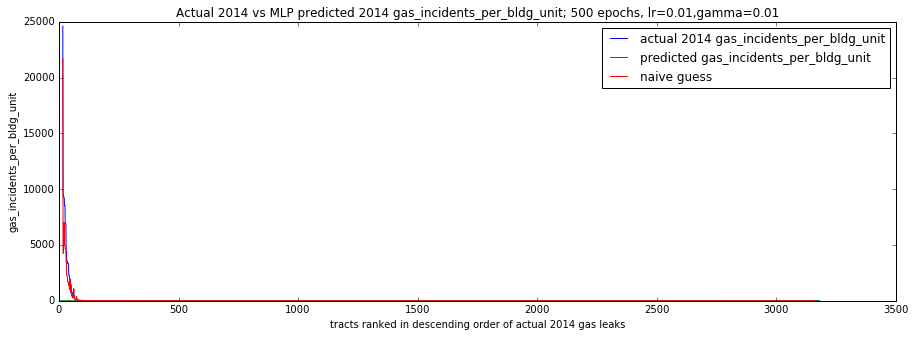

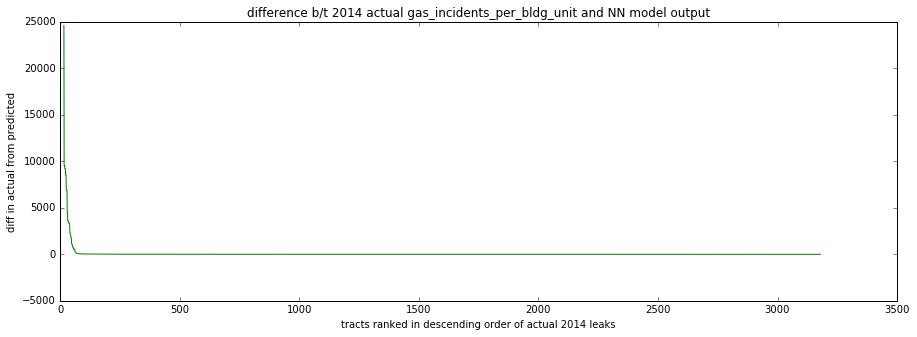

In [11]:
plot_mlp(model_1,epochs,learning,gamma=regular,final=False,cut=False,units=True)

In [12]:
model_1[2]

(0.73676129451172667, 0.89980579387090653)

2015 test with
- gamma: 0.01
- activation function: sigmoid (rmse 0.7367 vs tanh at 0.7369
- lr: 0.01 (rmse 0.7338 vs lr=0.001 at 0.7370 or lr=0.7367)
- hidden: 50 (rather than 100 or higher)
- seemed to find a consistent minimum around rmse 0.0073-0.0077

NOTES:
- found coarse-grained stability wrt lr, but hard to set lr too small at first...decay rate? (hessian matrix) http://stackoverflow.com/questions/35266370/tensorflow-compute-hessian-matrix-and-higher-order-derivatives
- top (>25% percentile)
- initial train 2013, train/test on 2014/2015 (i.e. 2nd train y should be 2014 data)

2015 RMSE: 0.89980579387090653

In [16]:
final_output = init_tract_2015.copy()
# final_output = final_output[final_output.ZipCode!=0]
final_output['naive'] = (init_tract_2013[
    'gas_incidents_per_bldg_unit']+init_tract_2014[
    'gas_incidents_per_bldg_unit'])/2
final_output['yhat'] = model_1[0]

In [52]:
final_output = final_output[['TRACT','geometry','ZipCode',
                 'total_gas_incidents','gas_incidents_per_bldg_unit',
                'naive','yhat']]

In [53]:
final_output.to_csv('djc_tract_baseline.csv',index=False)

### Aggregate to zipcode and calculate rmse

In [6]:
final_output = pd.read_csv(data_directory+'/djc_tract_baseline.csv')

In [7]:
zip_agg = final_output.groupby('ZipCode').sum().reset_index()
zip_agg['ZipCode'] = zip_agg['ZipCode'].astype(int).astype(str)

In [8]:
zip_15 = pd.read_csv(data_directory+'/pluto_fdny_dob_census_to_zipcode_2015.csv',
                     usecols=['geometry','ZipCode',
                 'total_gas_incidents','gas_incidents_per_bldg_unit'])
zip_15['ZipCode'] = zip_15['ZipCode'].astype(str)
zip_15 = zip_15.rename(columns={'total_gas_incidents':'total_actual_15',
                       'gas_incidents_per_bldg_unit':'per_unit_actual_15'})

zip_15.fillna(0, inplace=True)
zip_15 = zip_15.replace(np.inf, 0)

In [17]:
zip_merged = zip_agg.merge(zip_15,how='left',on='ZipCode')
zip_merged.fillna(0, inplace=True)
zip_merged = zip_merged.replace(np.inf, 0)
zip_merged = zip_merged[~zip_merged['ZipCode'].isin(['0',0])]
zip_merged = zip_merged[['ZipCode','TRACT','total_actual_15','per_unit_actual_15','naive','yhat']]

In [18]:
zip_rmse = np.sqrt(np.mean((zip_merged['yhat'] - zip_merged['per_unit_actual_15'])**2))

In [20]:
zip_merged.to_csv('djc_tract_agg_to_zip.csv',index=False)

In [21]:
zip_rmse

0.052942399313643453